# Exercise on Diffusion Models

Recently, diffusion models have been broadly used in generative AI:
- MidJourney (images),
- Suno AI (music),
- Sora (video),

and many others!

Despite being powerful and realistic, diffusion models remain conceptually simple to analyze. In this tutorial, we are going to code our own diffusion model.

Let us consider a situation where you have a dataset made of many images, for example flowers. As humans, we know that certain characteristics make an image look like a flower: the shape of the petals, the stem, typical colors, textures, etc.
Thus, generating a random flower requires respecting many constraints. Mathematically, it can be seen as drawing random images from a complicated probability distribution, which we call $P_{\rm real}$, representing the distribution of real flowers.

In the context of this practical session, using real flower images would require too much computational power.  
Therefore, we are going to focus on a simpler dataset that you might be familiar with: **MNIST**.  
Here, the distribution $P_{\rm real}$ corresponds to the distribution of handwritten digits that we want to sample from.

We will follow the usual procedure of diffusion models that we will explain on the way. Let us start with some introductory work.

## Import data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 784)
(10000, 784)


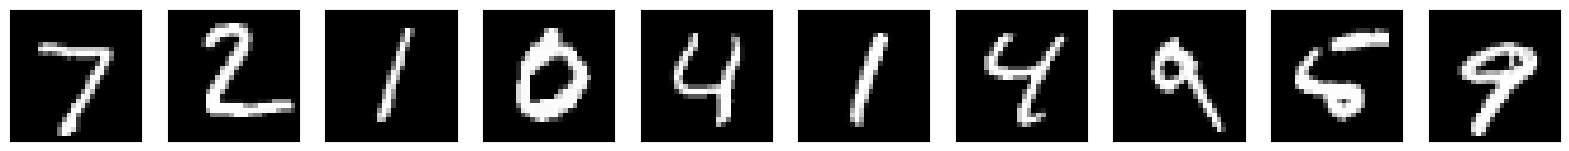

In [2]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import math

#We load the data
(x_train, _), (x_test, _) = mnist.load_data()

#We renormalize the data to a float in [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#We reshape the images to be 2d matrices of dimension n times d
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

#We plot the first ten images
%matplotlib inline

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Diffusions models use CNN architecture, let transform the data in an adapted shape for CNN.

In [3]:
# Reshaping the data for CNN
x_train_img = x_train.reshape(-1, 28, 28, 1).astype("float32")
x_test_img  = x_test.reshape(-1, 28, 28, 1).astype("float32")

x_train_img.shape, x_test_img.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## Denoising with CNN

Before coding the diffusion model, let us first code a CNN denoiser.

We note $\{ \mathbf{x}_{{\rm real},\, i} \}_{i \in [n]}$ the set of $n$ images of dimensions $d \times d$ contained in the dataset. We will artificially noise each of them for given values of noise $\sigma_i$ and train a CNN to denoise them. Let us highlight that the CNN is aware of the noise level $\sigma_i$ for each picture and will take this parameter in consideration during training.

Let us precise the setting. For each image $\mathbf{x}_{{\rm real},\, i} \in \mathbb{R}^{d \times d}$ we will add noise of magnitude $\sigma_i \in \mathbb{R}_+$. Then the noisy image is
$$\mathbf{x}_{{\rm noisy},\, i} = \mathbf{x}_{{\rm real},\, i} + \sigma_i \boldsymbol{\varepsilon}_i \, ,$$
where $\boldsymbol{\varepsilon}_i$ is an image of i.i.d. Gaussian pixels (each pixel distributed as $N(0,1)$).

Our goal is to train a CNN, $\mathbf{f}_{\mathbf{w}}$ that recovers the clean image from the noisy one, while also receiving the noise level $\sigma_i$ as an additional input.
The denoising loss for image $i$ is therefore:
$$ L_i(\mathbf{w}) = \left\|\, \mathbf{f}_{\mathbf{w}}(\mathbf{x}_{{\rm noisy},\, i}, \sigma_i) - \mathbf{x}_{{\rm real},\, i} \,\right\|^2$$
In practice, training is done in mini-batches that will have a size $B$.

Additionnally, for computationnal purpose, we will define an effective input $\mathbf{x}_{{\rm in},\, i}$ as the concatenation of $\mathbf{x}_{{\rm noisy},\, i}$ and $\sigma_i$, note that $\sigma_i$ must be transform in adapted shape. Another viewpoint, is to consider that the noise is another channel. For instance, for colorful images there are 3 channels (RGB), here there will be two (gray level, noise).  

For the range of noise values, we will define a set of possible values for the noise and we will choose them uniformly.

This will conclude the training part.

In [4]:
# Let's define the possible values for the noise.
SIGMA_SET = np.array([0.00, 0.05, 0.10, 0.20, 0.35, 0.50], dtype="float32")

# We create a function to pick them uniformly
def sample_sigma(batch_size):
    return np.random.choice(SIGMA_SET, size=(batch_size, 1, 1, 1)).astype("float32")

# For a given value of noise and a given image, compute the noisy image.
def add_noise(x, sigma):
    """
    x: (B,28,28,1) in [0,1]
    sigma: (B,1,1,1)
    -> x_noisy: (B,28,28,1)
    """
    eps = np.random.randn(*x.shape).astype("float32")
    x_noisy = x + sigma * eps
    return np.clip(x_noisy, 0.0, 1.0)

# Just a bit of formatting for giving to the network
def with_sigma_channel(x_noisy, sigma):
    """
    transform the scalar sigma as a constant image channel.
    -> (B,28,28,2)  [image_noisy, sigma_map]
    """
    sigma_map = np.tile(sigma, (1, 28, 28, 1))  # (B,28,28,1)
    return np.concatenate([x_noisy, sigma_map], axis=-1)

# Sanity check
_b = 8
_sigma = sample_sigma(_b)
_xn = add_noise(x_train_img[:_b], _sigma)
_xin = with_sigma_channel(_xn, _sigma)
_xin.shape


(8, 28, 28, 2)

In [5]:
BATCH = 128

# Let us define the function that creates the batches of data for training
def train_generator():
    N = x_train_img.shape[0]
    while True:
        idx = np.random.randint(0, N, size=(BATCH,))
        x_clean = x_train_img[idx]                                  # (B,28,28,1)
        sigma   = sample_sigma(BATCH)                                # (B,1,1,1)
        x_noisy = add_noise(x_clean, sigma)                          # (B,28,28,1)
        x_in    = with_sigma_channel(x_noisy, sigma)                 # (B,28,28,2)
        yield x_in, x_clean

# The same for test
def val_generator():
    N = x_test_img.shape[0]
    while True:
        idx = np.random.randint(0, N, size=(BATCH,))
        x_clean = x_test_img[idx]
        sigma   = sample_sigma(BATCH)
        x_noisy = add_noise(x_clean, sigma)
        x_in    = with_sigma_channel(x_noisy, sigma)
        yield x_in, x_clean

Now that almost all the pipeline is done, we just have to choose the architecture. Since the noise level is staying low (${\rm max} \sigma_i = 0.5$), we do not need a big architecture, the following will do.

In [6]:
from keras import layers, models, optimizers

model = models.Sequential([
    layers.Input(shape=(28, 28, 2)),                 # 1 image channel + 1 Ïƒ channel
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Conv2D(1,  3, padding="same", activation="sigmoid")  # output in [0,1]
])

model.compile(optimizer=optimizers.Adam(2e-4), loss="mse")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,857 (147.88 KB)

 Trainable params: 37,857 (147.88 KB)

 Non-trainable params: 0 (0.00 B)

Let's train the model!

In [7]:
steps_per_epoch = 60000 // BATCH
val_steps = 10000 // BATCH

hist = model.fit(
    train_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator(),
    validation_steps=val_steps,
    epochs=5
)


Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0669 - val_loss: 0.0054
Epoch 2/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0044 - val_loss: 0.0043


Now that the model is trained, we would like to see if on a test image, the CNN is able to denoise.

In [8]:
# Denoising
def denoise(x_clean_or_noisy, sigma_value):
    """
    x_clean_or_noisy: (B,28,28,1) en [0,1]
    sigma_value: float (ex: 0.2) or array shape (B,1,1,1)
    -> denoised image
    """
    if np.isscalar(sigma_value):  # Just to be sure that sigma is not already reshaped.
        sigma = np.full((x_clean_or_noisy.shape[0],1,1,1), float(sigma_value), dtype="float32")
    else:
        sigma = sigma_value.astype("float32")
    # add noise corresponding to sigma and append sigma channel before predicting
    x_noisy = add_noise(x_clean_or_noisy, sigma)
    x_in    = with_sigma_channel(x_noisy, sigma)
    return model.predict(x_in, verbose=0)


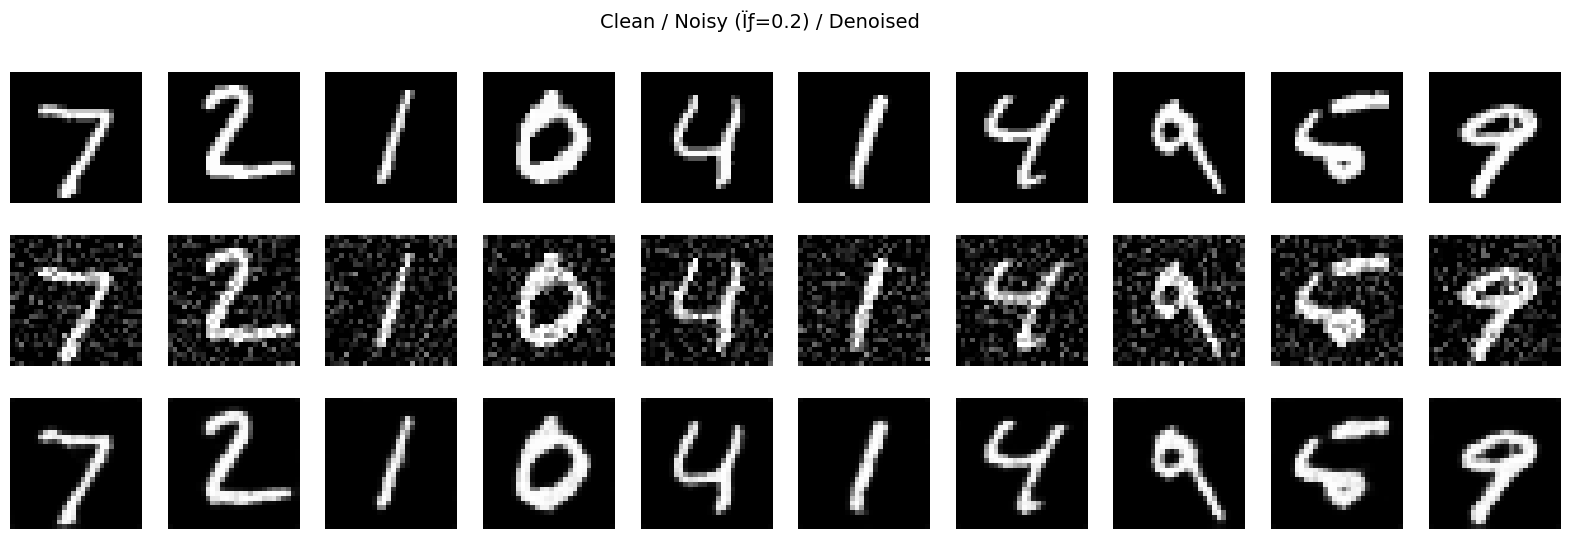

In [9]:
# Plotting for several images
n = 10
x0 = x_test_img[:n]
sigma_demo = 0.2


x_noisy = add_noise(x0, np.full((n,1,1,1), sigma_demo, dtype="float32"))
x_hat   = denoise(x0, sigma_demo)

plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1);   plt.imshow(x0[i].reshape(28,28));      plt.gray(); ax.set_axis_off()
    ax = plt.subplot(3, n, n+i+1); plt.imshow(x_noisy[i].reshape(28,28));  plt.gray(); ax.set_axis_off()
    ax = plt.subplot(3, n, 2*n+i+1); plt.imshow(x_hat[i].reshape(28,28)); plt.gray(); ax.set_axis_off()
plt.suptitle(f"Clean / Noisy (Ïƒ={sigma_demo}) / Denoised", y=0.98, fontsize=14)
plt.show()


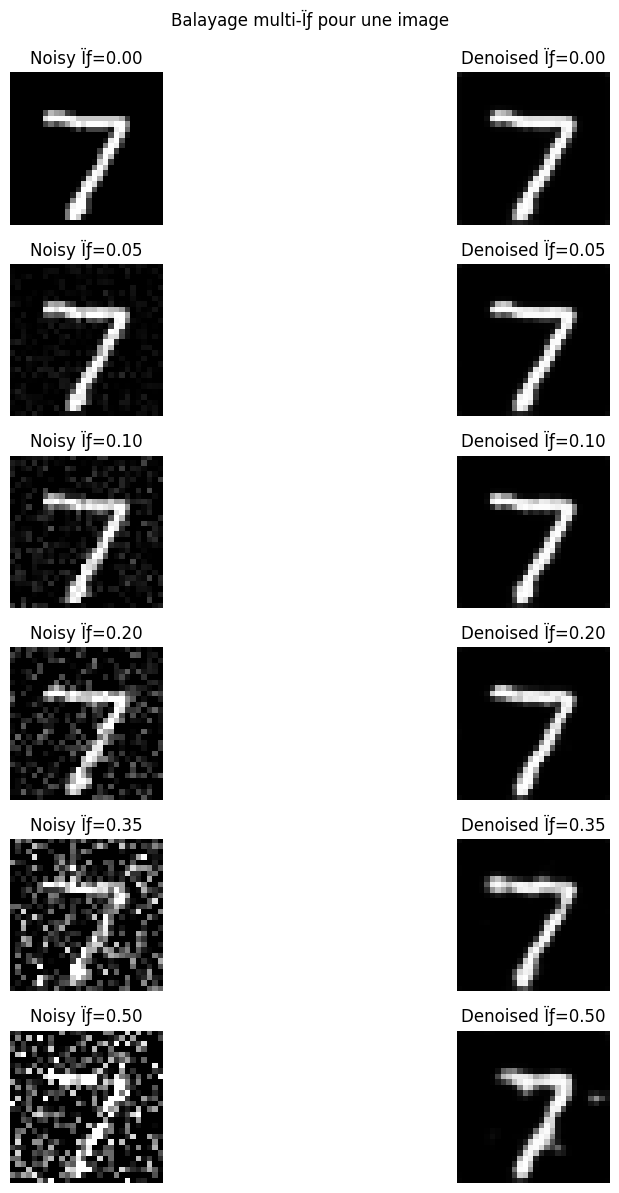

In [10]:
# Plotting for several values of sigma
idx = 0
x0 = x_test_img[idx:idx+1]  # (1,28,28,1)
sigmas = np.array([0.00, 0.05, 0.10, 0.20, 0.35, 0.50], dtype="float32")

imgs = []
titles = []
for s in sigmas:
    sigma = np.full((1,1,1,1), s, dtype="float32")
    x_noisy = add_noise(x0, sigma)
    x_hat   = denoise(x0, s)
    imgs += [x_noisy[0,...,0], x_hat[0,...,0]]
    titles += [f"Noisy Ïƒ={s:.2f}", f"Denoised Ïƒ={s:.2f}"]

plt.figure(figsize=(12, 2*len(sigmas)))
for i, (im, tl) in enumerate(zip(imgs, titles), 1):
    ax = plt.subplot(len(sigmas), 2, i); plt.imshow(im, cmap="gray"); ax.set_axis_off(); ax.set_title(tl)
plt.suptitle("Balayage multi-Ïƒ pour une image", y=0.99); plt.tight_layout(); plt.show()


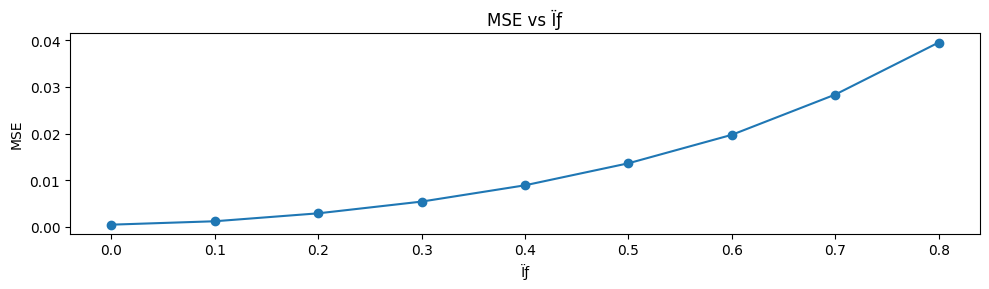

In [11]:
# Let's plot the MSE vs the noise level
def eval_curve(sigmas_eval, N=500):
    idx = np.random.choice(x_test_img.shape[0], size=N, replace=False)
    X = x_test_img[idx]
    mse_list, psnr_list = [], []
    for s in sigmas_eval:
        sigma = np.full((N,1,1,1), s, dtype="float32")
        X_noisy = add_noise(X, sigma)
        X_hat   = denoise(X, s)
        mse_list.append(np.mean((X_hat - X)**2))
    return np.array(mse_list)

sigmas_eval = np.linspace(0.0, 0.8, 9, dtype="float32")
mse_v = eval_curve(sigmas_eval, N=500)
plt.figure(figsize=(10,3))
plt.plot(sigmas_eval, mse_v, marker='o'); plt.xlabel("Ïƒ"); plt.ylabel("MSE"); plt.title("MSE vs Ïƒ")
plt.tight_layout(); plt.show()

## Deterministic Model

To build our first diffusion model, we now incorporate a notion of time into both the noising and the denoising process.  
More precisely, we define a continuous interpolation between the real image and pure Gaussian noise:

$$
\mathbf{x}_{{\rm noisy},\, i}(t)
= a(t)\,\mathbf{x}_{{\rm real},\, i}
+ b(t)\,\boldsymbol{\varepsilon}_i \, ,
$$

where $a(t)$ and $b(t)$ satisfy  
$$
{\rm at}\; t=0,\; \mathbf{x}_{{\rm noisy},\, i} = \mathbf{x}_{{\rm real},\, i}\, , \quad {\rm and} \;
{\rm at}\; t=T,\; \mathbf{x}_{{\rm noisy},\, i} = \boldsymbol{\varepsilon}_i\, .
$$
In other words, the parameter $t$ smoothly controls the noise intensity.  
During training, the role previously played by the noise level $\sigma_i$ is now replaced by the time index $t$.

This defines the ideal behaviour we want from our forward noising process.  
However, to implement diffusion properly, first, we need to describe the iterations. The forward dynamics are defined between successive timesteps by:
$$
\mathbf{x}_t
= \sqrt{\alpha_t}\,\mathbf{x}_{t-1}
\;+\;
\sqrt{1-\alpha_t}\,\boldsymbol{\varepsilon}_t,
\qquad
\boldsymbol{\varepsilon}_t \sim \mathcal{N}(0,I).
$$
From these local updates, one can show by expanding the recursion that $\mathbf{x}_t$ always admits the closed form
$$
\mathbf{x}_t
= \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0
\;+\;
\sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\varepsilon},
$$
where
$$
\bar{\alpha}_t \;=\; \alpha_1 \alpha_2 \cdots \alpha_t.
$$
This equation connects with our first approach through:
$$
a(t) = \sqrt{\bar{\alpha}_t}\,,
\quad
b(t) = \sqrt{1 - \bar{\alpha}_t}.
$$
One can also note:
$$
\alpha_t = \frac{\bar\alpha_t}{\bar\alpha_{t-1}} \, , \quad \beta_t = 1- \alpha_t\, .
$$
This more technical approach is essential to code the iteration of the forward and backward process.

Secondly, passing $t$ directly as a raw scalar to a CNN is not ideal.  
Convolutional networks operate through spatial filters, and they react better when the conditioning signal (here, time) is expressed in a richer form rather than as a single value.
This is why diffusion models typically use a time embedding based on simple Fourier features: instead of feeding $t$ alone, we feed several sinusoids of $t$ at different frequencies. This is nothing more than a feature map $\phi$ which also allows to increase the amount of parameters and improve the precision of the model.

More precisely, after normalizing $t_i$ into $[0,1]$, we define:
$$
\phi(t_i) =
\big(\sin(2\pi\,\omega_1 t_i),\; \cos(2\pi\,\omega_1 t_i),\; \dots,\;
      \sin(2\pi\,\omega_K t_i),\; \cos(2\pi\,\omega_K t_i) \big),
$$
where the frequencies are chosen as $\omega_k = 2^k$.  

They give the network a multi-scale description of the time index, which makes the conditioning on $t_i$ much easier to learn.  

Once the vector $\phi(t_i)$ is computed, we simply broadcast it across the spatial dimensions and concatenate it to the noisy image as additional channels.  
Thus, the network receives an input tensor of shape
$(d, d,\, 1 + 2K)$:
- $1$ channel for pixels values,
- $2K$ channels for the time embedding.

With this input, the denoising objective becomes:
$$
L_i(\mathbf{w}) =
\left\|\,
\mathbf{f}_{\mathbf{w}}\big(\mathbf{x}_{{\rm noisy},\, i}(t_i),\, \phi(t_i)\big)
- \mathbf{x}_{{\rm real},\, i}
\right\|^2.
$$

This time embedding mechanism is a crucial ingredient of modern diffusion models, and it ensures that the CNN can effectively learn how to denoise images at different stages of the diffusion process.

In [12]:
# Rescaling [0,1] -> [-1,1]
def to_symmetric(x):      # x in [0,1]
    return x * 2.0 - 1.0  # in [-1,1]

def from_symmetric(x):    # x in [-1,1]
    return np.clip((x + 1.0) * 0.5, 0.0, 1.0)


In [13]:
# The function used for time interpolation are cosines.
T = 200
t = (np.arange(T) + 0.5)/T
s = 0.008
f = lambda u: np.cos((np.pi/2)*(u+s)/(1+s))**2
alpha_bar = (f(t) / f(0)).astype("float32")
alpha = np.concatenate([[alpha_bar[0]], alpha_bar[1:]/alpha_bar[:-1]]).astype("float32")
beta  = (1.0 - alpha).astype("float32")

# We compute the noisy image at a given time
def q_sample(x0_sym, t_idx, eps):
    """x_t = sqrt(\bar{Î±}_t) x0 + sqrt(1-\bar{Î±}_t) Îµ"""
    a = np.sqrt(alpha_bar[t_idx]).reshape(-1,1,1,1).astype("float32")
    b = np.sqrt(1.0 - alpha_bar[t_idx]).reshape(-1,1,1,1).astype("float32")
    return a * x0_sym + b * eps

# Temporal embedding through Fourier feature (2K channels)
K = 8
def t_embed_map(t_idx, K=K):
    tt = (t_idx.astype("float32") / (T-1)).reshape(-1,1,1,1)  # in [0,1]

    # your code
    freqs = (2.0 ** np.arange(K)).reshape(1, K).astype("float32")               # [1,2,4,...]
    ang = 2.0 * np.pi * tt @ freqs                 # (B,1,1,K)
    sin = np.sin(ang)               # (B,1,1,K)
    cos = np.cos(ang)               # (B,1,1,K)
    emb = np.concatenate([sin, cos], axis=-1).reshape(-1,1,1,2*K)                # (B,1,1,2K)

    return np.tile(emb, (1,28,28,1)).astype("float32")        # (B,28,28,2K)

def make_input(x_like, t_idx):  # x_like: (B,28,28,1) en [-1,1]
    return np.concatenate([x_like, t_embed_map(t_idx, K=K)], axis=-1).astype("float32")

Architecture:

In [14]:
from keras import layers, models, optimizers, Input

CIN = 1 + 2*K  # 1 channel x_t + 2K time-embedding channels

inp = Input(shape=(28, 28, CIN))                       # 28x28

# --- Encoding level 1 (28x28) ---
e1 = layers.Conv2D(64, 3, padding="same", activation="swish")(inp)
e1 = layers.Conv2D(64, 3, padding="same", activation="swish")(e1)    # 28x28

# --- Encoding level 2 (14x14) ---
e2 = layers.Conv2D(128, 3, strides=2, padding="same", activation="swish")(e1)  # 14x14
e2 = layers.Conv2D(128, 3, padding="same", activation="swish")(e2)             # 14x14

# --- Bottleneck (14x14) ---
b  = layers.Conv2D(128, 3, padding="same", activation="swish")(e2)
b  = layers.Conv2D(128, 3, padding="same", activation="swish")(b)

# --- Decoder level 2 -> 1 (14x14 -> 28x28) ---
d1 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="swish")(b)  # 28x28
d1 = layers.Concatenate()([d1, e1])                                                   # skip connection
d1 = layers.Conv2D(64, 3, padding="same", activation="swish")(d1)
d1 = layers.Conv2D(64, 3, padding="same", activation="swish")(d1)

# --- Output: x0_hat in [-1,1] ---
out = layers.Conv2D(1, 3, padding="same", activation=None)(d1)

model_diff = models.Model(inp, out)
model_diff.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
model_diff.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28,    │          0 │ -                 │
│ (InputLayer)        │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      9,856 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │     73,856 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │    147,584 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 28, 28,    │     73,792 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28, 1) │        577 │ conv2d_11[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 748,481 (2.86 MB)

 Trainable params: 748,481 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
BATCH = 256

def diffusion_train_generator():
    N = x_train_img.shape[0]
    while True:
        idx = np.random.randint(0, N, size=(BATCH,))
        x0 = x_train_img[idx]                                # [0,1]
        x0_sym = to_symmetric(x0)                            # [-1,1]

        t_idx = np.random.randint(0, T, size=(BATCH,), dtype=np.int64)
        eps = np.random.randn(*x0.shape).astype("float32")   # Îµ ~ N(0,1)

        x_t = q_sample(x0_sym, t_idx, eps)                   # [-1,1]
        x_in = make_input(x_t, t_idx)

        yield x_in, x0_sym

Training!

In [16]:
steps_per_epoch = 60000 // BATCH
hist = model_diff.fit(diffusion_train_generator(),
                      steps_per_epoch=steps_per_epoch,
                      epochs=30)

Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - loss: 0.2144
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0904
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - loss: 0.0842
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0817
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0807
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0802
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.0801
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0791
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0779
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0781
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0775
Epoch 12/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0765
Epoch 13/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0771
Epoch 14/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0764
Epoch 15/30
234/234 ━━━━━━━━━

## Deterministic reverse process

Once the denoiser is trained, we can use it to run the diffusion process backwards.  
Recall that the forward noising step was defined as
$$
\mathbf{x}_t
= \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0
\;+\;
\sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\varepsilon}.
$$

In the deterministic reverse process, we start from pure noise at $t=T$ and move backwards to $t=0$.  
At each step, the model receives the current noisy image $\mathbf{x}_t$ together with its time embedding $\phi(t)$, and predicts an estimate of the clean image:
$$
\widehat{\mathbf{x}}_0 = \mathbf{f}_{\mathbf{w}}(\mathbf{x}_t , \phi(t)).
$$

With this estimate, we recover first the effective noise:
$$
\widehat{\boldsymbol{\varepsilon}}_t
=
\frac{\mathbf{x}_t - \sqrt{\bar{\alpha}_t}\,\widehat{\mathbf{x}}_0}
     {\sqrt{\,1-\bar{\alpha}_t\,}}.
$$

Secondly, we use the estimates $\widehat{\mathbf{x}}_0$ and $\widehat{\boldsymbol{\varepsilon}}_t$ but evaluated at $t-1$:
$$
\mathbf{x}_{t-1}
=
\sqrt{\bar{\alpha}_{t-1}}\,\widehat{\mathbf{x}}_0
\;+\;
\sqrt{1-\bar{\alpha}_{t-1}}\,\widehat{\boldsymbol{\varepsilon}}_t.
$$

No randomness is added in this process, so starting from the same initial noise always produces the same reconstructed image.  
This is the deterministic version of diffusion sampling.


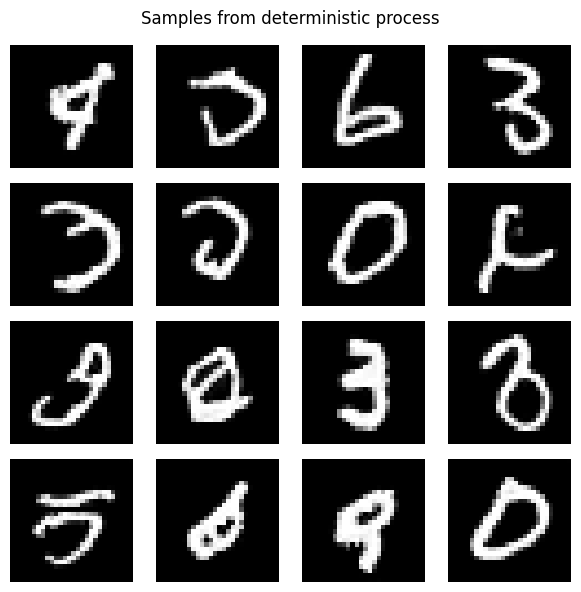

In [17]:
# (We want to repat the process 16 times to have a great plot!)

def sample_ddim(n=16, steps=100):
    t_seq = np.linspace(T-1, 0, steps, dtype=int)
    x = np.random.randn(n,28,28,1).astype("float32")  # x_T ~ N(0,1)

    for t in t_seq:
        t_arr = np.full((n,), t, dtype=np.int64)
        x_in = make_input(x, t_arr)

        ab_t   = float(alpha_bar[t])
        ab_prev= float(alpha_bar[t-1]) if t > 0 else 1.0

        # your code
        x0_hat = model_diff.predict(x_in, verbose=0).astype("float32")         # x0_hat in [-1,1]
        eps_hat = (x - np.sqrt(ab_t).astype("float32") * x0_hat) / (np.sqrt(1.0 - ab_t).astype("float32") + 1e-12)         # reconstituted ÎµÌ‚
        x = np.sqrt(ab_prev).astype("float32") * x0_hat + np.sqrt(1.0 - ab_prev).astype("float32") * eps_hat

    return from_symmetric(x)  # -> [0,1]

samples = sample_ddim(n=16, steps=200)

plt.figure(figsize=(6,6))
for i in range(min(16, samples.shape[0])):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(samples[i,...,0], cmap="gray", vmin=0.0, vmax=1.0)
    ax.set_axis_off()
plt.suptitle("Samples from deterministic process"); plt.tight_layout(); plt.show()


A really fancy type of videos that we see often try to show the forward and the backward pass. So that, from a test sample we can generate another one.

In [18]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def forward_noising_frames(x0_img01, n_frames=30):
    """x0_img01 shape (1,28,28,1) in [0,1]. Return frames with progressive noise."""
    x0s = to_symmetric(x0_img01)
    frames = [x0_img01[0,...,0]]
    t_seq = np.linspace(0, T-1, n_frames, dtype=int)
    for t in t_seq:
        eps = np.random.randn(*x0s.shape).astype("float32")
        x_t = q_sample(x0s, np.array([t]), eps)
        frames.append(from_symmetric(x_t[0,...,0]))
    return frames, int(t_seq[-1]), x_t

def reverse_from_xt_frames(x_t, t_start, n_frames=30, steps_per_frame=None):
    """
    Denoising from a given x_t (x_t in [-1,1]), until t=0.
    If steps_per_frame is None, we pick it to cover the whole interval.
    """
    frames = [from_symmetric(x_t[0,...,0])]
    t_cur = int(t_start)

    if steps_per_frame is None:
        steps_per_frame = max(1, math.ceil((t_cur + 1) / n_frames))

    for _ in range(n_frames):
        for _ in range(steps_per_frame):
            if t_cur < 0: break
            t = t_cur
            t_arr = np.full((1,), t, dtype=np.int64)
            x_in  = make_input(x_t, t_arr)

            x0_hat = model_diff.predict(x_in, verbose=0).astype("float32")
            ab_t   = float(alpha_bar[t])
            ab_prev= float(alpha_bar[t-1]) if t > 0 else 1.0
            eps_hat = (x_t - np.sqrt(ab_t).astype("float32") * x0_hat) / (np.sqrt(1.0 - ab_t).astype("float32") + 1e-10)
            x_t = np.sqrt(ab_prev).astype("float32") * x0_hat + np.sqrt(1.0 - ab_prev).astype("float32") * eps_hat

            t_cur  -= 1
        frames.append(from_symmetric(x_t[0,...,0]))
        if t_cur < 0:  # if already done, we replicate
            break

    # if you want exactly n+1 frames, you can pad:
    while len(frames) < n_frames + 1:
        frames.append(frames[-1])

    return frames


# Choice of a starting sample
idx = np.random.randint(0, x_test_img.shape[0])
x0_img = x_test_img[idx:idx+1]  # (1,28,28,1) en [0,1]

# Forward
fwd_frames, t_star, x_t_star = forward_noising_frames(x0_img, n_frames=25)

# Backward
rev_frames = reverse_from_xt_frames(x_t_star, t_star, n_frames=35, steps_per_frame=None)

frames = fwd_frames + rev_frames

fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap="gray", vmin=0, vmax=1); ax.axis("off")
def update(i): im.set_data(frames[i]); return [im]
ani = FuncAnimation(fig, update, frames=len(frames), interval=120)
plt.close()
HTML(ani.to_jshtml())


## Stochastic reverse process [Evaluated part]

The deterministic reverse process always produces the same final image when starting from the same initial noise.  
However, real diffusion models are probabilistic: at each step of the reverse trajectory, a small amount of randomness is injected, allowing the model to explore multiple plausible reconstructions.

The key idea is the following.  
Even if the forward noising process was defined as
$$
\mathbf{x}_t = a(t)\,\mathbf{x}_0 + b(t)\,\boldsymbol{\varepsilon},
$$
the reverse direction is not unique: the mapping from $\mathbf{x}_t$ back to $\mathbf{x}_{t-1}$ is not a single point but a whole probability distribution.  
Adding a stochastic component in the reverse step lets us sample from this distribution instead of collapsing to a single trajectory.

In practice, we proceed exactly as in the deterministic case: the model predicts an estimate $\widehat{\mathbf{x}}_0$ from $\mathbf{x}_t$ and $\phi(t)$. We can still recover the effective noise $\widehat{\boldsymbol{\varepsilon}}_t$ through the identity
$$
\mathbf{x}_t = a(t)\,\widehat{\mathbf{x}}_0 + b(t)\,\widehat{\boldsymbol{\varepsilon}}_t.
$$

The difference comes in the update rule. Instead of jumping deterministically to
$$
\mathbf{x}_{t-1}
= a(t-1)\,\widehat{\mathbf{x}}_0 + b(t-1)\,\widehat{\boldsymbol{\varepsilon}}_t,
$$
we add a controlled noise term:
$$
\mathbf{x}_{t-1}
= a(t-1)\,\widehat{\mathbf{x}}_0
\;+\; b(t-1)\,\widehat{\boldsymbol{\varepsilon}}_t
\;+\; \eta(t)\,\mathbf{z}_t,
$$
where $\mathbf{z}_t$ is a Gaussian noise and $\eta(t)$ controls the amount of randomness injected at step $t$. But what becomes the updates of the backward process?

With this new Gaussian noise, one can apply a central limit theorem. Namely, the next image $\mathbf{x}_{t-1}$ for a given $\mathbf{x}_{t}$ is gaussian:
$$
\mathbf{x}_{t-1} \,\big|\, \mathbf{x}_t \;\sim\; N \big(\,\boldsymbol{\mu}_t,\; c_t\,\mathbf{I}\big)\, ,
$$
$$
\mathbf{x}_{t-1} = \boldsymbol{\mu}_t + \sqrt{c_t}\,\mathbf{g}_t,
\qquad \mathbf{g}_t\sim\mathcal{N}(0,I).
$$
It leaves to compute the mean and the variance, after computation it comes:

- **Mean**
$$
\boldsymbol{\mu}_t
=
\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}\,\mathbf{x}_t
\;+\;
\frac{\sqrt{\bar{\alpha}_{t-1}}\,\beta_t}{1-\bar{\alpha}_t}\,
\widehat{\mathbf{x}}_0 ,
$$

- **Variance**
$$
c_t
=
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\,\beta_t.
$$

This stochastic variant allows the reverse process to generate different valid images from the same initial noise, illustrating the generative power of diffusion models.

The good news is that the difference from the deterministic model is in the reverse process, we do not need to re-train the model!

In [19]:
import numpy as np

def sample_ddpm(n=16):
    """
    Stochastic reverse diffusion:
    - start from x_T ~ N(0, I)
    - at each step t, predict x0_hat from (x_t, t)
    - compute the mean/variance
    - sample x_{t-1} from this Gaussian
    Returns samples in [0,1].
    """
    # x_T ~ N(0, I)
    x = np.random.randn(n, 28, 28, 1).astype("float32")

    for t in reversed(range(T)):
        t_arr = np.full((n,), t, dtype=np.int64)

        # predict x0_hat in [-1,1]
        x_in   = make_input(x, t_arr)
        x0_hat = model_diff.predict(x_in, verbose=0).astype("float32")

        # your code

        # diffusion coefficients at timestep t
        ab_t = float(alpha_bar[t])
        ab_prev = float(alpha_bar[t-1]) if t > 0 else 1.0
        a_t = np.sqrt(ab_t).astype("float32")
        b_t = np.sqrt(1.0 - ab_t).astype("float32")

        # reverse mean
        coef_xt = (np.sqrt(alpha[t]) * (1.0 - ab_prev)) / (1.0 - ab_t)
        coef_x0 = (np.sqrt(ab_prev) * (1.0 - alpha[t])) / (1.0 - ab_t)

        mean = coef_xt * x + coef_x0 * x0_hat

        # reverse variance
        var = ((1.0 - ab_prev) / (1.0 - ab_t)) * (1.0 - alpha[t])

        if t > 0:
            # stochastic step: add noise
            noise = np.random.randn(*x.shape).astype("float32")
            x = mean + np.sqrt(var) * noise
        else:
            # last step: no noise
            x = mean

    # convert [-1,1] â†’ [0,1]
    return from_symmetric(x)


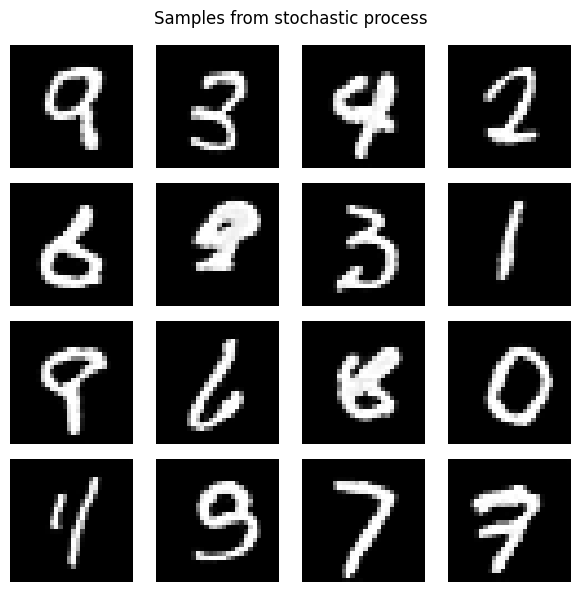

In [20]:
samples_ddpm = sample_ddpm(n=16)

plt.figure(figsize=(6,6))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(samples_ddpm[i,...,0], cmap="gray", vmin=0.0, vmax=1.0)
    ax.axis("off")
plt.suptitle("Samples from stochastic process"); plt.tight_layout(); plt.show()


We generate two deterministic runs and two stochastic runs starting from the exact same noised image.  
The deterministic ones allow us to check that the reverse process always gives the same result, while the stochastic ones illustrate that randomness can lead to different outcomes.  
Having all four side-by-side makes the contrast immediately visible.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# -------- 1) Forward noising process --------
def forward_noising_frames(x0_img01, n_frames=20):
    """
    Generates a sequence of progressively noised versions of a clean image.
    x0_img01 : (1,28,28,1) in [0,1]
    Returns: list of frames, final timestep t_star, and the noised x_t at t_star.
    """
    x0s = to_symmetric(x0_img01)          # map to [-1,1]
    frames = [x0_img01[0,...,0]]          # first frame = clean image
    t_seq = np.linspace(0, int(0.95*T), n_frames, dtype=int)

    x_t = None
    for t in t_seq:
        eps = np.random.randn(*x0s.shape).astype("float32")
        x_t = q_sample(x0s, np.array([t]), eps)            # forward process
        frames.append(from_symmetric(x_t[0,...,0]))
    return frames, int(t_seq[-1]), x_t


# -------- 2) Reverse deterministic --------
def reverse_ddim_from_xt_frames(x_t, t_start, n_frames=30):
    """
    Deterministic denoising starting from x_t at timestep t_start.
    Returns a list of intermediate frames for visualization.
    """
    frames = [from_symmetric(x_t[0,...,0])]
    t_cur = int(t_start)
    steps_per_frame = max(1, (t_cur+1) // n_frames)

    for _ in range(n_frames):
        for _ in range(steps_per_frame):
            if t_cur < 0:
                break
            t = t_cur
            t_arr = np.full((1,), t, dtype=np.int64)

            # deterministic x0-prediction model
            x_in   = make_input(x_t, t_arr)
            x0_hat = model_diff.predict(x_in, verbose=0).astype("float32")

            # your code

            ab_t    = float(alpha_bar[t])
            ab_prev = float(alpha_bar[t-1]) if t > 0 else 1.0

            # deterministic update
            eps_hat = (x_t - np.sqrt(ab_t) * x0_hat) / np.sqrt(1.0 - ab_t)
            x_t     = np.sqrt(ab_prev) * x0_hat + np.sqrt(1.0 - ab_prev) * eps_hat

            t_cur -= 1

        frames.append(from_symmetric(x_t[0,...,0]))
        if t_cur < 0:
            break

    return frames


# -------- 3) Reverse stochastic --------
def reverse_ddpm_from_xt_frames(x_t, t_start, n_frames=30):
    """
    Stochastic reverse process:
    adds Gaussian noise at every step except t=0.
    Returns intermediate frames for visualization.
    """
    frames = [from_symmetric(x_t[0,...,0])]
    t_cur = int(t_start)
    steps_per_frame = max(1, (t_cur+1) // n_frames)

    for _ in range(n_frames):
        for _ in range(steps_per_frame):
            if t_cur < 0:
                break
            t = t_cur
            t_arr = np.full((1,), t, dtype=np.int64)

            # x0-prediction model
            x_in   = make_input(x_t, t_arr)
            x0_hat = model_diff.predict(x_in, verbose=0).astype("float32")

            # your code

            ab_t    = float(alpha_bar[t])
            ab_prev = float(alpha_bar[t-1]) if t > 0 else 1.0
            a_t     = float(alpha[t])
            b_t     = float(beta[t])

            # stochastic mean
            coef_x0 = np.sqrt(ab_prev) * b_t / (1 - ab_t)
            coef_xt = np.sqrt(a_t) * (1 - ab_prev) / (1 - ab_t)
            mean    = coef_xt * x_t + coef_x0 * x0_hat

            # stochastic variance
            var = (1 - ab_prev) / (1 - ab_t) * b_t

            if t > 0:
                noise = np.random.randn(*x_t.shape).astype("float32")
                x_t   = mean + np.sqrt(var) * noise
            else:
                x_t   = mean

            t_cur -= 1

        frames.append(from_symmetric(x_t[0,...,0]))
        if t_cur < 0:
            break

    return frames


# -------- 4) 4-way animation: two deterministic runs + two stochastic runs --------
def four_run_diffusion_animation(n_fwd=20, n_back=30):
    """
    Produces an animation showing:
    - forward noising
    - two deterministic reverse runs
    - two stochastic reverse runs
    """
    # 1) sample a real test image
    idx = np.random.randint(0, x_test_img.shape[0])
    x0  = x_test_img[idx:idx+1]

    # 2) forward trajectory (shared)
    fwd_frames, t_star, x_t_star = forward_noising_frames(x0, n_frames=n_fwd)

    # 3) four reverse trajectories starting from the same x_t*
    ddim1 = reverse_ddim_from_xt_frames(x_t_star.copy(), t_star, n_frames=n_back)
    ddim2 = reverse_ddim_from_xt_frames(x_t_star.copy(), t_star, n_frames=n_back)
    ddpm1 = reverse_ddpm_from_xt_frames(x_t_star.copy(), t_star, n_frames=n_back)
    ddpm2 = reverse_ddpm_from_xt_frames(x_t_star.copy(), t_star, n_frames=n_back)

    # equalize sequence lengths
    L = max(len(ddim1), len(ddim2), len(ddpm1), len(ddpm2))
    for seq in (ddim1, ddim2, ddpm1, ddpm2):
        while len(seq) < L:
            seq.append(seq[-1])

    # 4) assemble composite frames
    frames = []

    # forward phase (same image in all 4 quadrants)
    for fr in fwd_frames:
        top    = np.concatenate([fr, fr], axis=1)
        bottom = np.concatenate([fr, fr], axis=1)
        tile   = np.concatenate([top, bottom], axis=0)
        frames.append(tile)

    # reverse trajectories
    for k in range(L):
        top    = np.concatenate([ddim1[k], ddim2[k]], axis=1)
        bottom = np.concatenate([ddpm1[k], ddpm2[k]], axis=1)
        tile   = np.concatenate([top, bottom], axis=0)
        frames.append(tile)

    # 5) animation rendering
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(frames[0], cmap="gray", vmin=0, vmax=1)
    ax.axis("off")

    ax_text_ddim = ax.text(-0.05, 0.75, "Deterministic", transform=ax.transAxes,
                           va="center", ha="right", fontsize=12, color="white")
    ax_text_ddpm = ax.text(-0.05, 0.25, "Stochastic", transform=ax.transAxes,
                           va="center", ha="right", fontsize=12, color="white")

    def update(i):
        im.set_data(frames[i])
        return [im, ax_text_ddim, ax_text_ddpm]

    ani = FuncAnimation(fig, update, frames=len(frames), interval=120)
    plt.close()
    return HTML(ani.to_jshtml())


# run the animation
four_run_diffusion_animation(n_fwd=20, n_back=30)

It might be that you are unlucky or you are lacking of computation power, There is an attached video that I obtained with a bigger network. Below is the network used for the attached picture. You can play with it, have fun.

In [22]:
# CIN = 1 + 2*K  # 1 channel x_t + 2K embedding time channels

# inp = Input(shape=(28, 28, CIN))                       # 28x28

# # --- Encoding level 1 (28x28) ---
# e1 = layers.Conv2D(256, 3, padding="same", activation="swish")(inp)
# e1 = layers.Conv2D(256, 3, padding="same", activation="swish")(e1)   # 28x28

# # --- Encoding level 2 (14x14) ---
# e2 = layers.Conv2D(512, 3, strides=2, padding="same", activation="swish")(e1)  # 14x14
# e2 = layers.Conv2D(512, 3, padding="same", activation="swish")(e2)             # 14x14

# # --- Bottleneck (14x14) ---
# b  = layers.Conv2D(512, 3, padding="same", activation="swish")(e2)
# b  = layers.Conv2D(512, 3, padding="same", activation="swish")(b)

# # --- Decoder level 2 -> 1 (14x14 -> 28x28) ---
# d1 = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="swish")(b)  # 28x28
# d1 = layers.Concatenate()([d1, e1])                                                    # skip
# d1 = layers.Conv2D(256, 3, padding="same", activation="swish")(d1)
# d1 = layers.Conv2D(256, 3, padding="same", activation="swish")(d1)

# # --- Output : x0_hat in [-1,1] ---
# out = layers.Conv2D(1, 3, padding="same", activation=None)(d1)

# model_diff = models.Model(inp, out)
# model_diff.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
# model_diff.summary()

![diffusion](https://github.com/YDIB11/FundamentalLearningEPFL/blob/main/TP12/diffusion.gif?raw=1)